<a href="https://colab.research.google.com/github/LordLean/Microsoft-Research-Sentence-Completion-Challenge/blob/main/MSRSCC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import os
import random, math
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import operator
import nltk 
from nltk import word_tokenize as tokenize
nltk.download("punkt")
nltk.download("wordnet")

from nltk.stem import 	WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()


import tqdm

# Download lab2 resources.
os.system("gdown --id 1H26pdLFh2cDxU-NkflQHzcNCYWUgHCbX")
os.system("unzip lab2resources.zip")

# Download scc resources.
os.system("gdown --id 155TLf2OdXtvfPD8VsWwI2YlHfjS8ph04")

from IPython.display import clear_output
clear_output()

In [ ]:
# Stopwords
from nltk.corpus import stopwords
nltk.download("stopwords")

import string

stop = set(stopwords.words("english"))
punc = string.punctuation

# Create stopword + punctuation list.
stop_puncs = (set([x for x in punc] + list(stop)))

In [ ]:
def get_training_testing(training_dir,split=0.5):

    filenames=os.listdir(training_dir)
    n=len(filenames)
    print("There are {} files in the training directory: {}".format(n,training_dir))
    # random.seed(53)  #if you want the same random split every time
    random.shuffle(filenames)
    index=int(n*split)
    trainingfiles=filenames[:index]
    heldoutfiles=filenames[index:]
    return trainingfiles,heldoutfiles

In [ ]:
parentdir="lab2resources/sentence-completion"
trainingdir=os.path.join(parentdir,"Holmes_Training_Data")
training,testing=get_training_testing(trainingdir)

## N-Gram model

In [ ]:
class n_gram_language_model():

    """
    N-gram language model class that stores n-grams and their probabilties learnt from training text
    in individiual dictionaries.

    Code adapted from the original work of Dr. J Weeds, University of Sussex.   
   
    Parameters
    ----------
    trainingdir : str
        The training directory where training data can be found.
    files : list
        List of file names to be trained on.
    test_files : list
        List of file names for the model to be tested on.
    construct_params : dict
        Stores the parameters such as known to initialize the language model with.
    Attributes
    ----------
    trainingdir : str
        The training directory where training data can be found.
    files : list
        List of file names to be trained on.
    test_files : list
        List of file names for the model to be tested on.
    construct_params : dict
        Stores the parameters such as known to initialize the language model with.
    verbose : bool
        Whether or not method calls will print progress.
    unigram : dict
        Dictionary to store unigram probabilities.
    bigram : dict
        Dictionary to store bigram probabilities.
    trigram : dict
        Dictionary to store trigram probabilities.
    4-gram : dict
        Dictionary to store 4-gram probabilities.
    """

    
    def __init__(self,trainingdir,files=[], test_files=[], construct_params={}):
        self.training_dir=trainingdir
        self.files=files
        self.test_files = test_files
        # Constructor Parameters.
        self.construct_params=construct_params
        self.verbose = construct_params.get("verbose", False)
        self.train()
        
    def train(self):    
        """
        Method called in model initialization. 
        Calls "private" methods which process files, make unknowns, discount and convert n-gram dictionaries to probabilities. 
        """
        self.unigram={}
        self.bigram={}
        self.trigram={}
        self.quad_gram={}
         
        self._processfiles()
        self._make_unknowns(known=self.construct_params.get("known",2))
        self._discount()
        self._convert_to_probs()

        
    
    def _processline(self,line):
        """
        Method processes lines of txt files and tokenizes sentences contained within.
        Information is stored within respective n-gram dictionaries.
        """
        tokens=tokenize(line)
        if self.construct_params.get("remove_stopwords",False) == True:
          tokens = [token.lower() for token in tokens if token.lower() not in stop_puncs]
        if self.construct_params.get("lemmatize", False) == True:
          tokens = [wordnet_lemmatizer.lemmatize(token) for token in tokens]
        tokens = ["__START"] + tokens + ["__END"]
        previous="__END"
        for i, token in enumerate(tokens):
            # Unigram
            self.unigram[token]=self.unigram.get(token,0)+1
            # Bigram
            current=self.bigram.get(previous,{})
            current[token]=current.get(token,0)+1
            self.bigram[previous]=current
            previous=token
            # Trigram
            if i < len(tokens)-2:
              # Next words.
              next = tokens[i+1] 
              next_next = tokens[i+2]
              # Get dictionaries.
              inner = self.trigram.get(token,{})
              innermost = inner.get(next,{})
              innermost[next_next] = innermost.get(token,0) + 1
              # Write frequencies to dictionaries.
              inner[next] = innermost
              self.trigram[token] = inner
            # 4-gram
            if i < len(tokens)-3:
              # Next words.
              next1 = tokens[i+1] 
              next2 = tokens[i+2]
              next3 = tokens[i+3]
              # Get dictionaries.
              inner1 = self.quad_gram.get(token,{})
              inner2 = inner1.get(next1,{})
              inner3 = inner2.get(next2,{})
              inner3[next3] = inner3.get(token,0) + 1
              # Write frequencies to dictionaries.
              inner2[next2] = inner3
              inner1[next1] = inner2
              self.quad_gram[token] = inner1

                      
            
    def _processfiles(self):
        """
        Process text files.
        """
        for afile in tqdm.tqdm(self.files):
            # print("Processing {}".format(afile))
            try:
                with open(os.path.join(self.training_dir,afile)) as instream:
                    for line in instream:
                        line=line.rstrip()
                        if len(line)>0:
                            self._processline(line)
            except UnicodeDecodeError:
              if self.verbose:
                print("UnicodeDecodeError processing {}: ignoring rest of file".format(afile))
              else:
                pass
      
            
    def _convert_to_probs(self):
        """
        Convert counts to probabilities for each n-gram dictionary.
        """
        self.unigram={k:v/sum(self.unigram.values()) for (k,v) in self.unigram.items()}
        self.bigram={key:{k:v/sum(adict.values()) for (k,v) in adict.items()} for (key,adict) in self.bigram.items()}
        self.trigram={k1:{k2:{k3:v/sum(adict2.values()) for k3, v in adict2.items()} for k2, adict2 in adict1.items()} for k1, adict1 in self.trigram.items()}
        self.quad_gram={k1:{k2:{k3:{k4:v/sum(adict3.values()) for k4, v in adict3.items()} for k3, adict3 in adict2.items()} for k2, adict2 in adict1.items()} for k1, adict1 in self.quad_gram.items()}
        self.kn={k:v/sum(self.kn.values()) for (k,v) in self.kn.items()}
    

    def nextlikely(self,k=1,current="",method="unigram"):
        #use probabilities according to method to generate a likely next sequence
        #choose random token from k best
        blacklist=["__START","__UNK","__DISCOUNT"]
        most_likely = []
        if method=="unigram":
            dist=self.unigram
            #sort the tokens by unigram probability
            most_likely=sorted(list(dist.items()),key=operator.itemgetter(1),reverse=True)
        elif method == "bigram":
            dist=self.bigram.get(current,self.bigram.get("__UNK",{}))
            most_likely=sorted(list(dist.items()),key=operator.itemgetter(1),reverse=True)
        elif method == "trigram":
            # Split context string for first and second context words.
            context = current.split()
            c1, c2 = context[0], context[1]
            dist = self.trigram[c1][c2]
            # Get all words with maximum value.
            most_likely = [(k, _) for k, v in dist.items() if v == max(dist.values())]
        elif method == "quad_gram":
            context = current.split(" ")
            c1,c2,c3 = context[0], context[1], context[2]
            dist = self.quad_gram[c1][c2][c3]
            most_likely = [(k, _) for k, v in dist.items() if v == max(dist.values())]
        #filter out any undesirable tokens
        filtered=[w for (w,p) in most_likely if w not in blacklist]
        #choose one randomly from the top k
        res=random.choice(filtered[:k])
        return res
    
    def generate(self,k=3,end="__END",limit=20,method="bigram",methodparams={}):
        """
        Example sentence generator method: Shannon Visualizations.
        k selects from the best top(k)s.
        """
        if method=="":
            method=methodparams.get("method","bigram")
        current="__START"
        tokens=[]
        try: 
          # Trigram
          if method=="trigram":
            # Set current word to first context.
            context_1 = current
            # Set random choice of next word to second context.
            context_2 = random.choice([key for key, adict in self.trigram[current].items()])
            # Check end token hasnt been reached.
            while context_2 != end and len(tokens)<limit:
              # Pass current contexts to next likely method which re splits them in the tri- 4-gram cases.
              current = " ".join([context_1, context_2])
              current = self.nextlikely(k=k, current=current, method=method)
              # Append word to the list that will eventually be generated.
              tokens.append(current)
              # Set the the second context to now be first and the predicted word (current) to be next.
              context_1 = context_2
              context_2 = current
            # After loop return the tokens joined by whitespace.
            return " ".join(tokens[:-1])
          # Quad-Gram
          elif method == "quad_gram":
            # Functionality is the same as above with an additional context variable to account for 4 rather than 3 n-grams.
            context_1 = current
            context_2 = random.choice([key for key, adict in self.quad_gram[context_1].items()])
            context_3 = random.choice([key for key, adict in self.quad_gram[context_1][context_2].items()])
            while context_3 != end and len(tokens) < limit: 
              current = " ".join([context_1, context_2, context_3])
              current = self.nextlikely(k=k, current=current, method=method)
              tokens.append(current)
              context_1 = context_2
              context_2 = context_3
              context_3 = current
            return " ".join(tokens[:-1])
        except:
          # If error is thrown rerun method until it generates a valid sentence.
          return self.generate(k=k,end=end,limit=limit,method=method,methodparams=methodparams)
        # Below calls the unigram and bigram versions of the method.
        while current!=end and len(tokens)<limit:
            current=self.nextlikely(k=k,current=current,method=method)
            tokens.append(current)
        return " ".join(tokens[:-1])
    
    
    def get_prob(self,token,context="",methodparams={}):
        if methodparams.get("method","unigram")=="unigram":
            return self.unigram.get(token,self.unigram.get("__UNK",0))
        else:
            if methodparams.get("smoothing","kneser-ney")=="kneser-ney":
                unidist=self.kn
            else:
                unidist=self.unigram
            bigram=self.bigram.get(context[-1],self.bigram.get("__UNK",{}))
            big_p=bigram.get(token,bigram.get("__UNK",0))
            lmbda=bigram["__DISCOUNT"]
            uni_p=unidist.get(token,unidist.get("__UNK",0))
            #print(big_p,lmbda,uni_p)
            p=big_p+lmbda*uni_p            
            return p
    
    
    def compute_prob_line(self,line,methodparams={}):
        """
        Refactored method which calls get_probs() for uni- and bigram cases. Contains functionality for tri- and 4-gram cases within.
        Method is not commented as it should be self explanatory:
        Lots of if else statements to fit the contexts into a n-gram dictionary. 
        
        #this will add _start to the beginning of a line of text
        #compute the probability of the line according to the desired model
        #and returns probability together with number of tokens
        """
        tokens=tokenize(line)
        if self.construct_params.get("remove_stopwords",False) == True:
          tokens = [token.lower() for token in tokens if token.lower() not in stop_puncs]
        if self.construct_params.get("lemmatize", False) == True:
          tokens = [wordnet_lemmatizer.lemmatize(token) for token in tokens]
        tokens = ["__START"] + tokens + ["__END"]
        acc=0
        if methodparams.get("method", "unigram") in ["unigram", "bigram"]:
          for i,token in enumerate(tokens[1:]):
            acc+=math.log(self.get_prob(token,tokens[:i+1],methodparams))
          return acc,len(tokens[1:])
        # Trigram. 
        if methodparams.get("method") == "trigram":
          try:
            for i, token in enumerate(tokens[1:]):
              if i < len(tokens[1:]) - 3 and len(tokens[1:]) >= 3:
                word1, word2, word3 = tokens[i+1], tokens[i+1+1], tokens[i+1+2]
                if word1 in self.trigram:
                  if word2 in self.trigram[word1]:
                    if word3 in self.trigram[word1][word2]:
                      acc+=math.log(self.trigram[word1][word2][word3])
                    else:
                      acc+=math.log(self.trigram[word1][word2]["__UNK"])
                  else:
                    if word3 in self.trigram[word1]["__UNK"]:
                      acc+=math.log(self.trigram[word1]["__UNK"][word3])
                    else: 
                      acc+=math.log(self.trigram[word1]["__UNK"]["__UNK"])
                else:
                  if word2 in self.trigram["__UNK"]:
                    if word3 in self.trigram["__UNK"][word2]:
                      acc+=math.log(self.trigram["__UNK"][word2][word3])
                    else:
                      acc+=math.log(self.trigram["__UNK"][word2]["__UNK"])
                  else:
                    if word3 in self.trigram["__UNK"]["__UNK"]:
                      acc+=math.log(self.trigram["__UNK"]["__UNK"][word3])
                    else:
                      acc+=math.log(self.trigram["__UNK"]["__UNK"]["__UNK"])
            return acc, len(tokens[1:])
          except KeyError:
            return acc, len(tokens[1:]) 
        # Quad_gram - same as above. FYI - if else if statements are used rather than if elif to enhance readability.
        if methodparams.get("method") == "quad_gram":
          try:
            for i, token in enumerate(tokens[1:]):
              if i < len(tokens[1:]) - 4 and len(tokens[1:]) >= 4:
                word1, word2, word3, word4 = tokens[i+1], tokens[i+1+1], tokens[i+1+2], tokens[i+1+3]
                if word1 in self.quad_gram:
                  if word2 in self.quad_gram[word1]:
                    if word3 in self.quad_gram[word1][word2]:
                      if word4 in self.quad_gram[word1][word2][word3]:
                        acc+=math.log(self.quad_gram[word1][word2][word3][word4])
                      elif "__UNK" in self.quad_gram[word1][word2][word3]:
                        acc+=math.log(self.quad_gram[word1][word2][word3]["__UNK"])
                    else:
                      if word4 in self.quad_gram[word1][word2]["__UNK"]:
                        acc+=math.log(self.quad_gram[word1][word2]["__UNK"][word4])
                      elif "__UNK" in self.quad_gram[word1][word2]["__UNK"]:
                        acc+=math.log(self.quad_gram[word1][word2]["__UNK"]["__UNK"])
                  else:
                    if "__UNK" in self.quad_gram[word1]:
                      if word3 in self.quad_gram[word1]["__UNK"]:
                        if word4 in self.quad_gram[word1]["__UNK"][word3]:
                          acc+=math.log(self.quad_gram[word1]["__UNK"][word3][word4])
                        elif "__UNK" in self.quad_gram[word1]["__UNK"][word3]:
                          acc+=math.log(self.quad_gram[word1]["__UNK"][word3]["__UNK"])
                      else:
                        if "__UNK" in self.quad_gram[word1]["__UNK"]:
                          if word4 in self.quad_gram[word1]["__UNK"]["__UNK"]:
                            acc+=math.log(self.quad_gram[word1]["__UNK"]["__UNK"][word4])
                          elif "__UNK" in self.quad_gram[word1]["__UNK"]["__UNK"]:
                            acc+=math.log(self.quad_gram[word1]["__UNK"]["__UNK"]["__UNK"])
                else:
                  if "__UNK" in self.quad_gram:
                    if word2 in self.quad_gram["__UNK"]:
                      if word3 in self.quad_gram["__UNK"][word2]:
                        if word4 in self.quad_gram["__UNK"][word2][word3]:
                          acc+=math.log(self.quad_gram["__UNK"][word2][word3][word4])
                        elif "__UNK" in self.quad_gram["__UNK"][word2][word3]:
                          acc+=math.log(self.quad_gram["__UNK"][word2][word3]["__UNK"])
                      else:
                        if word4 in self.quad_gram["__UNK"][word2]["__UNK"]:
                          acc+=math.log(self.quad_gram["__UNK"][word2]["__UNK"][word4])
                        elif "__UNK" in self.quad_gram["__UNK"][word2]["__UNK"]:
                          acc+=math.log(self.quad_gram["__UNK"][word2]["__UNK"]["__UNK"])
                    else:
                      if "__UNK" in self.quad_gram["__UNK"]:
                        if word3 in self.quad_gram["__UNK"]["__UNK"]:
                          if word4 in self.quad_gram["__UNK"]["__UNK"][word3]:
                            acc+=math.log(self.quad_gram["__UNK"]["__UNK"][word3][word4])
                          elif "__UNK" in self.quad_gram["__UNK"]["__UNK"][word3]:
                            acc+=math.log(self.quad_gram["__UNK"]["__UNK"][word3]["__UNK"])
                        else:
                          if "__UNK" in self.quad_gram["__UNK"]["__UNK"]:
                            if word4 in self.quad_gram["__UNK"]["__UNK"]["__UNK"]:
                              acc+=math.log(self.quad_gram["__UNK"]["__UNK"]["__UNK"][word4])
                            elif "__UNK" in self.quad_gram["__UNK"]["__UNK"]["__UNK"]:
                              acc+=math.log(self.quad_gram["__UNK"]["__UNK"]["__UNK"]["__UNK"])
            return acc, len(tokens[1:])
          except KeyError:
            return acc, len(tokens[1:]) 
            
    
    def compute_probability(self,filenames=[],methodparams={}):
        #computes the probability (and length) of a corpus contained in filenames
        if filenames==[]:
            filenames=self.files
        total_p=0
        total_N=0
        for i,afile in enumerate(filenames):
          if self.verbose:
            print("Processing file {}:{}".format(i,afile))
          try:
              with open(os.path.join(self.training_dir,afile)) as instream:
                  for line in instream:
                      line=line.rstrip()
                      if len(line)>0:
                          p,N=self.compute_prob_line(line,methodparams=methodparams)
                          total_p+=p
                          total_N+=N
          except UnicodeDecodeError:
            if self.verbose:
              print("UnicodeDecodeError processing file {}: ignoring rest of file".format(afile))
            else:
              pass
        return total_p,total_N
    
    def compute_perplexity(self,filenames=[],methodparams={"method":"bigram","smoothing":"kneser-ney"}):
        """
        compute the probability and length of the corpus
        calculate perplexity
        lower perplexity means that the model better explains the data
        """
        p,N=self.compute_probability(filenames=filenames,methodparams=methodparams)
        # print(p,N)
        if methodparams.get("method") in ["trigram", "quad_gram"]:
          rem = self.super_counter[methodparams.get("method")] - self.magic_counter[methodparams.get("method")]
          pp=math.exp(-p/N) * (self.super_counter[methodparams.get("method")]/rem)
          return pp
        pp=math.exp(-p/N)
        return pp  
    

    def _make_unknowns(self,known=2):
        """
        Method to distribute probability mass towards the unknown token.
        param known (int): dictates cut off point where n-grams less frequent than known are pruned.
        """
        # Unigram -----------------------------------
        for (k,v) in list(self.unigram.items()):
            if v<known:
                del self.unigram[k]
                self.unigram["__UNK"]=self.unigram.get("__UNK",0)+v
        # Bigram -----------------------------------
        for (k,adict) in list(self.bigram.items()):
            for (kk,v) in list(adict.items()):
                isknown=self.unigram.get(kk,0)
                if isknown <= known:
                    adict["__UNK"]=adict.get("__UNK",0)+v
                    del adict[kk]
            isknown=self.unigram.get(k,0)
            if isknown <= known:
                del self.bigram[k]
                current=self.bigram.get("__UNK",{})
                current.update(adict)
                self.bigram["__UNK"]=current
            else:
                self.bigram[k]=adict
        # Trigram -----------------------------------
        for (k1, dict1) in list(self.trigram.items()):
          for (k2, dict2) in list(dict1.items()):
            for (k3, val) in list(dict2.items()):
              isknown=self.unigram.get(k3,0)
              if isknown == 0:
                dict2["__UNK"] = dict2.get("__UNK",0) + val
                del dict2[k3]
            isknown=self.unigram.get(k2,0)
            if isknown <= known:
              del self.trigram[k1][k2]
              current=self.trigram[k1].get("__UNK",{})
              current.update(dict2)
              self.trigram[k1]["__UNK"] = current
            else:
              self.trigram[k1][k2] = dict2
          # For first token:
          isknown=self.unigram.get(k1,0)
          if isknown <= known:
            del self.trigram[k1]
            current = self.trigram.get("__UNK",{})
            current.update(dict1)
            self.trigram["__UNK"] = current 
          else:
            self.trigram[k1] = dict1
        # Quad Gram -----------------------------------
        for (k1, dict1) in list(self.quad_gram.items()):
          for (k2, dict2) in list(dict1.items()):
            for (k3, dict3) in list(dict2.items()):
              for (k4, val) in list(dict3.items()):
                # Next
                isknown = self.unigram.get(k4,0)
                if isknown <= known:
                  dict3["__UNK"] = dict3.get("__UNK",0) + val
                  del dict3[k4]
              # Next
              isknown=self.unigram.get(k3,0)
              if isknown <= known:
                del self.quad_gram[k1][k2][k3]
                current = self.quad_gram[k1][k2].get("__UNK", {})
                current.update(dict3)
                self.quad_gram[k1][k2]["__UNK"] = current
              else:
                self.quad_gram[k1][k2][k3] = dict3
            # Next
            isknown=self.unigram.get(k2,0)
            if isknown <= known:
              del self.quad_gram[k1][k2]
              current = self.quad_gram[k1].get("__UNK",{})
              current.update(dict2)
              self.quad_gram[k1]["__UNK"] = current
            else:
              self.quad_gram[k1][k2] = dict2
          # Next
          isknown=self.unigram.get(k1,0)
          if isknown <= known:
            del self.quad_gram[k1]
            current = self.quad_gram.get("__UNK", {})
            current.update(dict1)
            self.quad_gram["__UNK"] = current
          else:
            self.quad_gram[k1] = dict1

                
    def _discount(self,discount=0.75):
        #discount each bigram count by a small fixed amount
        self.bigram={k:{kk:value-discount for (kk,value) in adict.items()}for (k,adict) in self.bigram.items()}
        
        #for each word, store the total amount of the discount so that the total is the same 
        #i.e., so we are reserving this as probability mass
        for k in self.bigram.keys():
            lamb=len(self.bigram[k])
            self.bigram[k]["__DISCOUNT"]=lamb*discount
            
        #work out kneser-ney unigram probabilities
        #count the number of contexts each word has been seen in
        self.kn={}
        for (k,adict) in self.bigram.items():
            for kk in adict.keys():
                self.kn[kk]=self.kn.get(kk,0)+1
    

# Word Embedding methods

### Pre-trained

In [ ]:
# Note - uses gensim version 4.0.1
import gensim.downloader as api

fasttext_model300 = api.load('fasttext-wiki-news-subwords-300')
word2vec_model300 = api.load('word2vec-google-news-300')
glove_model300 = api.load('glove-wiki-gigaword-300')

In [ ]:
def processfiles(max_files=10):
    """
    Code adapted from n_gram_language_model class definition.
    Returns lists of preprocessed and not tokenized sentences.
    """
    sentences = []
    sentences_preprocessed = []
    for afile in tqdm.tqdm(training):
        # print("Processing {}".format(afile))
        try:
            with open(os.path.join(trainingdir,afile)) as instream:
                for line in instream:
                    line=line.rstrip()
                    if len(line)>0:
                        tokens = [token for token in tokenize(line) if token not in stop_puncs]
                        sentences_preprocessed.append(tokens)
                        tokens = [token for token in tokenize(line)]
                        sentences.append(tokens)
        except UnicodeDecodeError:
            print("\nUnicodeDecodeError processing {}: ignoring rest of file".format(afile))
    return sentences, sentences_preprocessed

In [ ]:
# Code to create gensim models to be trained on gutenberg text.
from gensim.models import Word2Vec, FastText

def create_word2vec_gensim(sentences, window=5, vector_size=100, skip_gram=1, negative=5, alpha=0.05, epochs=15, seed=1):
  return Word2Vec(sentences,
                  window = window,
                  vector_size = vector_size,
                  sg = skip_gram,
                  negative = negative,
                  alpha = alpha,
                  epochs = epochs,
                  seed = seed)
    

def create_fasttext_gensim(sentences, window=5, vector_size=100, skip_gram=1, negative=5, alpha=0.05, epochs=15, min_n=3, max_n=6, seed=1):
  return FastText(sentences,
                  window = window,
                  vector_size = vector_size,
                  sg = skip_gram,
                  negative = negative,
                  alpha = alpha,
                  epochs = epochs,
                  min_n = min_n,
                  max_n = max_n,
                  seed = seed)

# Ensemble


### N-gram

In [ ]:
construct_params = {
    "known" : 5,
    "verbose" : False,
    "remove_stopwords" : True
}

# Initialize n-gram language model.
lm=n_gram_language_model(trainingdir=trainingdir,files=training, test_files=[], construct_params=construct_params)

100%|██████████| 261/261 [07:05<00:00,  1.63s/it]


In [ ]:
additional_args = {"n_gram_model" : lm, "pre_emb_model" : fasttext_model300, "ensemble" : True}

# Questions and Answers


In [ ]:
import pandas as pd, csv
questions=os.path.join(parentdir,"testing_data.csv")
answers=os.path.join(parentdir,"test_answer.csv")

with open(questions) as instream:
    csvreader=csv.reader(instream)
    lines=list(csvreader)
qs_df=pd.DataFrame(lines[1:],columns=lines[0])

##  Building and evaluating an SCC system


In [ ]:
class question:

    """
    Question class which stores information about a singular MSR SCC question.

    Code adapted from the original work of  Dr. J Weeds, University of Sussex.   
   
    Parameters
    ----------
    aline : str
        The training directory where training data can be found.
    files : list
        List of file names to be trained on.
    test_files : list
        List of file names for the model to be tested on.
    construct_params : dict
        Stores the parameters such as known to initialize the language model with.
    Attributes
    ----------
    trainingdir : str
        The training directory where training data can be found.
    files : list
        List of file names to be trained on.
    test_files : list
        List of file names for the model to be tested on.
    construct_params : dict
        Stores the parameters such as known to initialize the language model with.
    verbose : bool
        Whether or not method calls will print progress.
    unigram : dict
        Dictionary to store unigram probabilities.
    bigram : dict
        Dictionary to store bigram probabilities.
    trigram : dict
        Dictionary to store trigram probabilities.
    4-gram : dict
        Dict
    """
    

    def __init__(self,aline,stop=True):
        self.fields=aline
        self.num2letter = {
            0:"a",
            1:"b",
            2:"c",
            3:"d",
            4:"e"
            }
        self.stop = stop
        if self.stop:
          self.tokenized = [token.lower() for token in tokenize(self.fields[1]) if token.lower() not in stop_puncs]
          # self.tokenized = [wordnet_lemmatizer.lemmatize(token) for token in self.tokenized]
        else:
          self.tokenized = tokenize(self.fields[1])
        self.options = self.fields[2:7]
        self.backoff_factor = 0.4
          

    def get_field(self,field):
        return self.fields[question.colnames[field]]
    

    def add_answer(self,fields):
        self.answer=fields[1]
   

    def get_context(self,window,target="_____",method="left"):
      """
      Method to return the context of a target word in question sentence. 
      If not sufficient context the method returns context with unknown token padding.
      """
      for i, token in enumerate(self.tokenized):
        if token == target:
            if method=="left":
              try:
                return self.tokenized[i-window:i]
              except:
                return ["__UNK"] * window
            elif method=="right": 
              return self.tokenized[i+1:i+1+window]


    def chooseA(self):
        return("a")


    def random(self):
      """
      Retrun random choice of letter.
      """
      return random.choice(self.num2letter)


    def unigram(self):
      """
      Return position of word with greatest unigram probability. 0 otherwise.
      """
      option_probs = [lm.unigram[word] if word in lm.unigram else 0 for word in self.options]
      index = option_probs.index(max(option_probs))
      return self.num2letter[index]


    def bigram(self, context_dir="left"): # Backoff
      """
      Return position of word-pair with greatest bigram probability. 0 otherwise. 
      """
      option_probs = []
      context = self.get_context(1, method=context_dir) # [0] to delist context.
      context = ["__UNK"] + context
      if context_dir == "left":
        for word in self.options:
          # Bigram.
          if context[-1] in lm.bigram and word in lm.bigram[context[-1]]:
            option_probs.append(lm.bigram[context[-1]][word])
          # Back off to unigram
          elif word in lm.unigram:
            option_probs.append(self.backoff_factor * lm.unigram[word])
          else:
            option_probs.append(0)
      elif context_dir == "right":
        option_probs = [lm.bigram[word][context] if word in lm.bigram and context in lm.bigram[word] else 0 for word in self.options]
      index = option_probs.index(max(option_probs))
      return self.num2letter[index]


    def trigram(self, context_dir="left"): # Backoff
      """
      Return position of word-group with greatest trigram probability. 0 otherwise. 
      """
      option_probs = []
      context = self.get_context(2, method=context_dir)
      context = ["__UNK"] * 2 + context 
      if context_dir == "left":
        for word in self.options:
          if context[-2] in lm.trigram and context[-1] in lm.trigram[context[-2]] and word in lm.trigram[context[-2]][context[-1]]:
            option_probs.append(lm.trigram[context[-2]][context[-1]][word])
          # Back off to bigram.
          elif context[-1] in lm.bigram and word in lm.bigram[context[-1]]:
            option_probs.append(self.backoff_factor * lm.bigram[context[-1]][word])
          # Back off to unigram.
          elif word in lm.unigram:
            option_probs.append(self.backoff_factor * self.backoff_factor * lm.unigram[word])
          # Else 0.
          else:
            option_probs.append(0)
      index = option_probs.index(max(option_probs))
      return self.num2letter[index]


    def quad_gram(self, context_dir="left"): # Backoff
      """
      Return position of word-group with greatest trigram probability. 0 otherwise. 
      """
      option_probs = []
      context = self.get_context(3, method=context_dir)
      context = ["__UNK"] * 3 + context
      for word in self.options:
        if context[-3] in lm.quad_gram and context[-2] in lm.quad_gram[context[-3]] and context[-1] in lm.quad_gram[context[-3]][context[-2]] and word in lm.quad_gram[context[-3]][context[-2]][context[-1]]:
          option_probs.append(lm.quad_gram[context[-3]][context[-2]][context[-1]][word])
        # Back off to trigram.
        elif context[-2] in lm.trigram and context[-1] in lm.trigram[context[-2]] and word in lm.trigram[context[-2]][context[-1]]:
          option_probs.append(self.backoff_factor * lm.trigram[context[-2]][context[-1]][word])
        # Back off to bigram.
        elif context[-1] in lm.bigram and word in lm.bigram[context[-1]]:
          option_probs.append((self.backoff_factor**2) *lm.bigram[context[-1]][word])
        # Back off to unigram.
        elif word in lm.unigram:
          option_probs.append((self.backoff_factor**3) * lm.unigram[word])
        # Else 0.
        else:
          option_probs.append(0)
      index = option_probs.index(max(option_probs))
      return self.num2letter[index]
   

    def simple_4_gram(self, additional_args={}):
      lm = additional_args.get("n_gram_model")
      option_probs = []
      left_context = self.get_context(3, method="left")
      left_context = ["__UNK"] * 3 + left_context
      con1 = left_context[-3]
      con2 = left_context[-2]
      con3 = left_context[-1]
      right_context = self.get_context(3, method="right")
      right_context = right_context + ["__UNK"] * 3
      r_con1 = right_context[0]
      r_con2 = right_context[1]
      r_con3 = right_context[2]
      for word in self.options:
        try:
          score = 0
          # Bigram
          if word in lm.bigram.get(con3,{}):
            score += 1
          if r_con1 in lm.bigram.get(word,{}):
            score += 1
          # Trigram
          if word in lm.trigram.get(con3,{}).get(con2,{}):
            score += 2
          if r_con1 in lm.trigram.get(con3,{}).get(word,{}):
            score += 2
          if r_con2 in lm.trigram.get(word,{}).get(r_con1,{}):
            score += 2
          # Quad_gram
          if word in lm.quad_gram.get(con1,{}).get(con2,{}).get(con3,{}):
            score += 3
          if r_con1 in lm.quad_gram.get(con2,{}).get(con3,{}).get(word,{}):
            score += 3
          if r_con2 in lm.quad_gram.get(con3,{}).get(word,{}).get(r_con1,{}):
            score += 3
          if r_con3 in lm.quad_gram.get(word,{}).get(r_con1,{}).get(r_con2,{}):
            score += 3
          option_probs.append(score)
        except TypeError:
          print([con1,con2,con3,word,r_con1,r_con2,r_con3])
          option_probs.append(0)
      # -------------
      # Ensemble
      if additional_args.get("ensemble", False):
        return option_probs
      # -------------
      index = option_probs.index(max(option_probs))
      return self.num2letter[index]


    def embedding_similarity(self, method="cos", additional_args={}):
      """
      For use with pretrained or even custom embeddings.
      """
      model = additional_args.get("pre_emb_model")
      option_probs = []
      # Remove target string.
      sentence = self.tokenized #.remove("_____")
      # Iterate through candidate choices.
      for word in self.options:
        try:
          # If no embedding for that word exists.
          if word not in model.wv:
            option_probs.append(0)
            # Continue to next candidate word.
            continue
          # Get vectorized form of word.
          word_vector = model.wv.get_vector(word)
          # Get vectorized form of sentence tokens.
          sentence_vectors = [model.wv.get_vector(sent_token) for sent_token in sentence if sent_token in model.wv and sent_token != "_____"]
          # For euclidean distances.
          if method == "euc":
            sim_score = [np.linalg.norm(model.wv.get_vector(word) - model.wv.get_vector(sent_token)) for sent_token in sentence if sent_token in model.wv and sent_token != "_____"]
          # For cosine distances.
          else:
            sim_score = model.wv.cosine_similarities(word_vector, sentence_vectors)
          # Append average "method" similarity.
          option_probs.append(sum(sim_score)/len(sim_score))
        except (TypeError, np.AxisError, ZeroDivisionError) as e:
          print(sentence)
          option_probs.append(0)
      # ----------------
      # Ensemble - cosine:
      if additional_args.get("ensemble", False):
        return option_probs
      # ----------------
      if method == "cos":
        index = option_probs.index(max(option_probs))
      else:
        index = option_probs.index(min(option_probs))
      return self.num2letter[index]


    def ensemble(self, additional_args={}):
      """
      Ensemble method which aggregates scores of both tested models and normalizes + sums them.
      """
      n_gram_model = additional_args.get("n_gram_model")
      n_gram = self.simple_4_gram(additional_args=additional_args)
      norm_n_gram = [float(i)/sum(n_gram) if sum(n_gram) !=0 else 0 for i in n_gram]

      pre_emb_model = additional_args.get("pre_emb_model")
      pre_emb = self.embedding_similarity(additional_args=additional_args)
      norm_pre_emb = [float(i)/sum(pre_emb) if sum(pre_emb) !=0 else 0 for i in pre_emb]

      option_probs = [sum(val) for val in zip(norm_n_gram, norm_pre_emb)]
      index = option_probs.index(max(option_probs))
      return self.num2letter[index]


  # ################################################### comment below to use stupid backoff.
    def bigram(self, context_dir="left"):
      """
      Return position of word-pair with greatest bigram probability. 0 otherwise. 
      """
      try:
        context = self.get_context(1, method=context_dir)[0] # [0] to delist context.
      except:
        context = ["__START"][0] 
      if context_dir == "left":
        option_probs = [lm.bigram[context][word] if context in lm.bigram and word in lm.bigram[context] else 0 for word in self.options]
      elif context_dir == "right":
        option_probs = [lm.bigram[word][context] if word in lm.bigram and context in lm.bigram[word] else 0 for word in self.options]
      index = option_probs.index(max(option_probs))
      return self.num2letter[index]


    def trigram(self, context_dir="left"): 
      """
      Return position of word-group with greatest trigram probability. 0 otherwise. 
      """
      option_probs = []
      try:
        context = ["__UNK"] * 2 + self.get_context(2, method=context_dir)
      except:
        context = ["__UNK"] * 2 + context
      if context_dir == "left":
        for word in self.options:
          if context[-2] in lm.trigram and context[-1] in lm.trigram[context[-2]] and word in lm.trigram[context[-2]][context[-1]]:
            option_probs.append(lm.trigram[context[-2]][context[-1]][word])
          elif context[-2] in lm.trigram and context[-1] in lm.trigram[context[-2]] and "__UNK" in lm.trigram[context[-2]][context[-1]]:
            option_probs.append(lm.trigram[context[-2]][context[-1]]["__UNK"])
          # Else 0.
          else:
            option_probs.append(0)
      index = option_probs.index(max(option_probs))
      return self.num2letter[index]


    def quad_gram(self, context_dir="left"):
      """
      Return position of word-group with greatest trigram probability. 0 otherwise. 
      """
      option_probs = []
      context = ["__UNK"] * 3 + self.get_context(3, method=context_dir)
      con_len = len(context)
      for word in self.options:
        if context[-3] in lm.quad_gram and context[-2] in lm.quad_gram[context[-3]] and context[-1] in lm.quad_gram[context[-3]][context[-2]] and word in lm.quad_gram[context[-3]][context[-2]][context[-1]]:
          option_probs.append(lm.quad_gram[context[-3]][context[-2]][context[-1]][word])
        elif context[-3] in lm.quad_gram and context[-2] in lm.quad_gram[context[-3]] and context[-1] in lm.quad_gram[context[-3]][context[-2]] and "__UNK" in lm.quad_gram[context[-3]][context[-2]][context[-1]]:
          option_probs.append(lm.quad_gram[context[-3]][context[-2]][context[-1]]["__UNK"])
        else:
          option_probs.append(0)
      index = option_probs.index(max(option_probs))
      return self.num2letter[index]
    
    def quad_gram(self, context_dir="left"):
      """
      Return position of word-group with greatest trigram probability. 0 otherwise. 
      """
      option_probs = []
      context = ["__UNK"] * 3 + self.get_context(3, method=context_dir)
      con1, con2, con3 = context[-3], context[-2], context[-1]
      try:
        if con1 not in lm.quad_gram:
          con1 = "__UNK"
        if con2 not in lm.quad_gram[con1]:
          con2 = "__UNK"
        if con3 not in lm.quad_gram[con1][con2]:
          con3 = "__UNK"
        for word in self.options:
          if con1 in lm.quad_gram and con2 in lm.quad_gram[con1] and con3 in lm.quad_gram[con1][con2] and word in lm.quad_gram[con1][con2][con3]:
            option_probs.append(lm.quad_gram[con1][con2][con3][word])
          elif con1 in lm.quad_gram and con2 in lm.quad_gram[con1] and con3 in lm.quad_gram[con1][con2] and "__UNK" in lm.quad_gram[con1][con2][con3]:
            option_probs.append(lm.quad_gram[con1][con2][con3]["__UNK"])
          else:
            option_probs.append(0)
      except KeyError:
        option_probs.append(0)
      index = option_probs.index(max(option_probs))
      return self.num2letter[index]
  # ################################################### 
    
    
    def predict(self, method="chooseA", additional_args=None):
        if method=="chooseA":
          return self.chooseA()
        elif method=="random":
          return self.random()
        elif method=="unigram":
          return self.unigram()
        elif method=="bigram":
          return self.bigram()
        elif method=="trigram":
          return self.trigram()
        elif method=="quad_gram":
          return self.quad_gram()
        elif method=="simple_4_gram":
          return self.simple_4_gram(additional_args=additional_args)
        elif method=="embedding_similarity":
          return self.embedding_similarity(additional_args=additional_args)
        elif method=="ensemble":
          return self.ensemble(additional_args=additional_args)
        elif method == "cos":
          return self.embedding_similarity(additional_args=additional_args)
        elif method == "euc":
          return self.embedding_similarity(additional_args=args,method="euc")


    def predict_and_score(self, method="chooseA", additional_args=None):
        #compare prediction according to method with the correct answer
        #return 1 or 0 accordingly
        # Method also records which questions were answered correctly by index.
        prediction=self.predict(method=method, additional_args=additional_args)
        if prediction == self.answer:
            correct_answers.get(method).append(1)
            return 1
        else:
            correct_answers.get(method).append(0)
            return 0

In [ ]:
class scc_reader:
    

    def __init__(self,qs=questions,ans=answers,stop=False):
        self.qs=qs
        self.ans=ans
        self.stop = stop
        self.read_files()


    def read_files(self):
        
        #read in the question file
        with open(self.qs) as instream:
            csvreader=csv.reader(instream)
            qlines=list(csvreader)
        
        #store the column names as a reverse index so they can be used to reference parts of the question
        question.colnames={item:i for i,item in enumerate(qlines[0])}
        
        #create a question instance for each line of the file (other than heading line)
        self.questions=[question(qline, self.stop) for qline in qlines[1:]]
        
        #read in the answer file
        with open(self.ans) as instream:
            csvreader=csv.reader(instream)
            alines=list(csvreader)
            
        #add answers to questions so predictions can be checked    
        for q,aline in zip(self.questions,alines[1:]):
            q.add_answer(aline)


    def get_field(self,field):
        return [q.get_field(field) for q in self.questions] 
    

    def predict(self,method="chooseA"):
        return [q.predict(method=method) for q in self.questions]
    
    def predict_and_score(self,method="chooseA", additional_args=None):
        scores=[q.predict_and_score(method=method, additional_args=additional_args) for q in self.questions]
        return sum(scores)/len(scores)

## Ensemble

In [ ]:
correct_answers = {"simple_4_gram" : [], "embedding_similarity" : [], "ensemble" : []}

In [ ]:
# Simple-4-gram score
additional_args = {"n_gram_model" : lm, "pre_emb_model" : fasttext_model300, "ensemble" : False}
SCC = scc_reader(questions, answers, stop=True)
SCC.predict_and_score(method="simple_4_gram", additional_args=additional_args)

0.3576923076923077

In [ ]:
# Embedding similarity score
SCC = scc_reader(questions, answers, stop=True)
SCC.predict_and_score(method="embedding_similarity", additional_args=additional_args)

['_____']
['_____']
['_____']
['_____']
['_____']


0.43173076923076925

In [ ]:
# Ensemble score
additional_args["ensemble"] = True
SCC = scc_reader(questions, answers, stop=True)
SCC.predict_and_score(method="ensemble", additional_args=additional_args)

['_____']
['_____']
['_____']
['_____']
['_____']


0.4394230769230769

## Error Analysis

In [ ]:
import warnings  
warnings.filterwarnings(action='ignore') #,category=DeprecationWarning,module='gensim')

In [ ]:
#read in the answer file
holding_list = []
with open("lab2resources/sentence-completion/test_answer.csv") as instream:
    csvreader=csv.reader(instream)
    alines=list(csvreader)
    holding_list.append(alines)
answers = [holding_list[0][i][1] for i, _ in enumerate(holding_list[0]) if i != 0]

In [ ]:
# All correct.
correct = []
# All incorrect.
incorrect = []
# N-gram incorrect
n_g_incorrect = []
# n-g over emb.
n_g_vs_emb = []
# emb over n-g.
emb_vs_n_g = []
# ensemble got right when other two didnt.
ensemble_solved = []
# Ensemble favouring n-gram.
n_g_favour = []
# Ensemble favouring word embeddings.
emb_favour = []
# Ensemble only.
ensemble_only = []

for i, (n_g, emb, ensemble) in enumerate(zip(correct_answers["simple_4_gram"], correct_answers["embedding_similarity"], correct_answers["ensemble"])):
  if n_g == emb == ensemble == 1:
    correct.append(i)
  if n_g == emb == ensemble == 0:
    incorrect.append(i)
  if n_g == 1 and emb == 0:
    n_g_vs_emb.append(i)
  if n_g == 0 and emb == 1:
    emb_vs_n_g.append(i)
  if n_g == emb == 0 and ensemble == 1:
    ensemble_solved.append(i)
  if n_g == 0:
    n_g_incorrect.append(i)

  if n_g == 0 and ensemble == 1 == emb:
    emb_favour.append(i)
  if emb == 0 and ensemble == 1 == n_g:
    n_g_favour.append(i)

  if ensemble == 1:
    ensemble_only.append(i)

In [ ]:
def error_analysis(index):
  """
  Function to print out the answers predicted by each model stated, as well as the question (tokenized and not) and the correct answer.
  """

  q = question([SCC.get_field("id")[index], SCC.get_field("question")[index], SCC.get_field("a)")[index], SCC.get_field("b)")[index],SCC.get_field("c)")[index], SCC.get_field("d)")[index], SCC.get_field("e)")[index]])
  answer = answers[index]
  
  additional_args = {"n_gram_model" : lm, "pre_emb_model" : fasttext_model300, "ensemble" : False}
  pred_ngram = q.predict("simple_4_gram", additional_args=additional_args)
  answer_ngram = SCC.get_field("{})".format(pred_ngram))[index]
  
  pred_emb = q.predict("embedding_similarity", additional_args=additional_args)
  answer_emb = SCC.get_field("{})".format(pred_emb))[index]
  
  additional_args["ensemble"] = True
  pred_ensemble = q.predict("ensemble", additional_args=additional_args)
  answer_ensemble = SCC.get_field("{})".format(pred_ensemble))[index]

  answer_correct = SCC.get_field("{})".format(answers[index]))[index]

  # print()
  print("------------------------------")
  print(SCC.get_field("question")[index])
  print(q.tokenized)
  print()
  print(answer_correct)
  print()
  print("N-gram: {}".format(answer_ngram))
  print("Embedd: {}".format(answer_emb))
  print("Ensemb: {}".format(answer_ensemble))
  print("------------------------------")
  print()


In [ ]:
[error_analysis(index) for index in ensemble_solved]

# Development + graphing functions

In [ ]:
# Example development code for experimenting with the known parameter.
lm_known = {}
MAX_FILES=100

training_shuffled = shuffle(training)
training_shuffled = training_shuffled[:MAX_FILES]

num = 0.2
train, test = train_test_split(training_shuffled,test_size=num)

for known in [5, 10, 25, 50]:


  construct_params = {
      "known" : known,
      "verbose" : False,
      "remove_stopwords" : True
  }

  # Initialize n-gram language model.
  lm=n_gram_language_model(trainingdir=trainingdir,files=train, test_files=test, construct_params=construct_params)

  lm_known[known] = lm

In [ ]:
knowns_test = [lm.compute_perplexity(filenames=lm.test_files,methodparams={"method":method}) for lm in lm_stop.values() for method in ["unigram", "bigram", "trigram", "quad_gram"]]

In [ ]:
def chunker(lst, n):
    """
    Chunnk lst (list) into n chunks.
    """
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [ ]:
vocab_size = [len(lm.unigram) for lm in lm_stop.values()]

In [ ]:
one = []
two = []
three = []
four = []
for i_l in list(chunker(knowns_test,4)):
  one.append(i_l[0])
  two.append(i_l[1])
  three.append(i_l[2])
  four.append(i_l[3])

In [ ]:
data_preproc = pd.DataFrame({
    'Training Doc Size': [key for key, lm in lm_stop.items()], 
    'unigram': one,
    'bigram': two,
    "trigram":three,
    '4-gram': four,
    'vocab': vocab_size,
    })

data_preproc

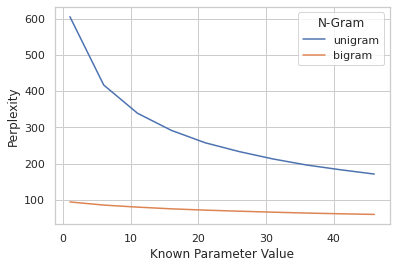

In [ ]:
# Graphing function.
ax = sns.lineplot(x='knowns', y='value', hue='variable', 
             data=pd.melt(data_preproc, ['knowns']))

ax.set(xlabel="Known Parameter Value", ylabel="Perplexity")
# ax._legend.set_title("N-Gram")
leg = ax.legend()
leg.set_title("N-Gram")

[Text(0, 0.5, 'Word Token'), Text(0.5, 0, 'Frequency')]

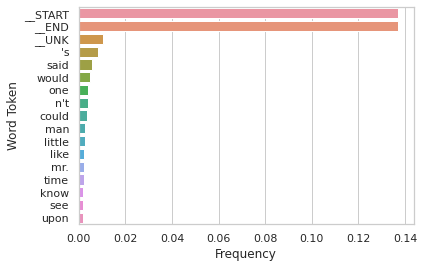

In [ ]:
import seaborn as sns
sns.set_theme(style="whitegrid")

keys = [p[0] for p in gg]
val = [p[1] for p in gg]

ax = sns.barplot(y=keys, x=val, orient="horizontal")
ax.set(xlabel="Frequency", ylabel="Word Token")